In [1]:
import json
import pycbc
from pycbc import psd
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform import ringdown
from pycbc.filter import matchedfilter as mtch
import matplotlib.pyplot as plt
import pykerr as pk
from pycbc import conversions as cn
import numpy as np

In [2]:
file_path = '/Users/arnauduranmayol/Desktop/TFM/Ten_years_lensed_3G_rd.json'
with open(file_path, 'r') as file:
    # Load the JSON data
    pop_l = json.load(file)
print(pop_l[1])

{'zl': 0.4986159007085284, 'zs': 5.194928449532275, 'sigma': 140.61113294329152, 'q': 0.7617359562449239, 'e1': 0.11821318928618171, 'e2': -0.06570049248931559, 'gamma1': 0.023075740215740437, 'gamma2': -0.04668926265809917, 'Dl': 1295.705089493929, 'Ds': 1299.221225563385, 'Dls': 985.7770485138219, 'theta_E': 2.097507239540362e-06, 'gamma': 2.1130773896237165, 'mass_1_source': 7.5571082614893035, 'mass_2_source': 7.552832442464204, 'psi': 3.044067353655405, 'phase': 2.4010282080051217, 'geocent_time': 1238654326.0, 'ra': 3.17151386965285, 'dec': 0.3582546354503939, 'tilt_1': 0.0, 'tilt_2': 0.0, 'phi_12': 0.0, 'phi_jl': 0.0, 'n_images': 2.0, 'x0_image_positions': [-0.9005895163940618, 0.6498994046856252, nan, nan], 'x1_image_positions': [-0.8341982130788091, 0.3084996281877304, nan, nan], 'magnifications': [4.175683737281196, -1.7834876449988495, nan, nan], 'time_delays': [0.0, 675961.8249051592, nan, nan], 'image_type': [1.0, 2.0, 0.0, 0.0], 'weights': 1.0, 'opt_snr_net': [46.46493766

In [3]:
file_path_2 = '/Users/arnauduranmayol/Desktop/TFM/Ten_years_unlensed_3G_rd.json'
with open(file_path_2, 'r') as file:
    # Load the JSON data
    pop_Nol = json.load(file)
print(pop_Nol[0])

{'mass_1': 43.07386044284564, 'mass_2': 42.4108079301749, 'mass_1_source': 9.265919722722149, 'mass_2_source': 9.123285854032611, 'zs': 3.6486330263814737, 'luminosity_distance': 32869.98612644974, 'iota': 2.0725141506711093, 'psi': 2.7577444873539716, 'phase': 5.886898143122066, 'geocent_time': 1257820635.0, 'ra': 5.732650608267193, 'dec': -0.2884554694207128, 'a_1': 0.237543208635962, 'a_2': 0.6933572410202696, 'tilt_1': 0.0, 'tilt_2': 0.0, 'phi_12': 0.0, 'phi_jl': 0.0, 'opt_snr_net': 15.226039226141317, 'ET': 4.769302840194664, 'CE': 14.4598070849685, 'opt_snr_net_rd': 1.2645030865366422}


In [4]:
#SET MINIMUM SNR
min_snr = 10

## DON'T RUN
This part of the code finds the SNR and puts it in the json files.

In [8]:
import time

start_time = time.time()
# set index = -1 if you want to run the whole set and index = 10 if you want just to run ten cases and estimate the time it would take
index = -1
population_l = []
for year_1 in pop_l[0:]: 
    dic_data = {}
    dic_data['mass1'] = year_1['mass1']
    dic_data['mass2'] = year_1['mass2']
    dic_data['spin1z'] = year_1['spin1z']
    dic_data['spin2z'] = year_1['spin2z']
    dic_data['inclination'] = year_1['inclination']
    dic_data['distance'] = year_1['distance']
    dic_data['delta_t']= 1/1024
    dic_data['approximant']= 'IMRPhenomPv2'
    dic_data['f_lower']= 3
    population_l.append(get_td_waveform(**dic_data))
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
print("Estimation time for %d elements:"% (len(pop_l)), len(pop_l)/index*execution_time, "seconds")

Execution time: 124.45999097824097 seconds
Estimation time for 821 elements: -102181.65259313583 seconds


/Users/arnauduranmayol/aduran/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


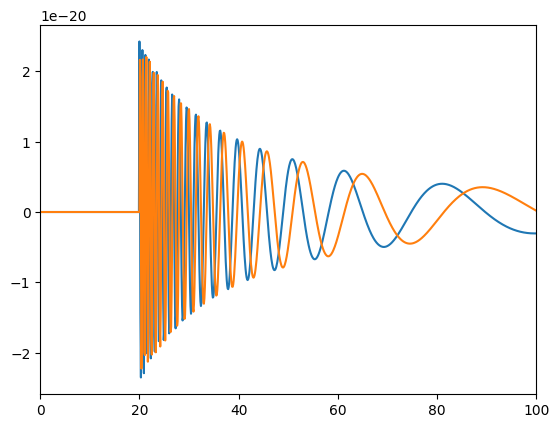

In [9]:
hp,hc=get_fd_waveform(approximant='IMRPhenomD',mass1=20,mass2=20,delta_f=0.1,f_lower = 20)
plt.plot(hp.sample_frequencies,hp)
plt.plot(hc.sample_frequencies,hc)
plt.xlim(0,100)
plt.show()

In [10]:
snr_rd = []
snr_all = []
snr_rd_n = []
snr_all_n = []
start_time = time.time()
#LENSED

for i in range(len(pop_l)):
    h_waveform = population_l[i][0]-1j*population_l[i][1]
    h_phase = np.angle(h_waveform)
    index = (h_waveform).data.argmax()
    h_phase_wrap = np.unwrap(h_phase)
    h_freq = np.gradient(h_phase_wrap,h_waveform.sample_times)
    frd = abs(h_freq[index]/(2*np.pi)) 

    try:
        snr_ratio_2 = mtch.sigmasq(population_l[i][0],low_frequency_cutoff=frd)/mtch.sigmasq(population_l[i][0])
        snr_total = pop_l[i]['opt_snr_net']
        snr_total = np.array([x for x in snr_total if not np.isnan(x)])
        snr_total_2 = (np.linalg.norm(snr_total))**2
        snr_inspiral_2 = snr_total_2*(1-snr_ratio_2)
        snrrd2 = np.sqrt(snr_total_2 - snr_inspiral_2)
        pop_l[i]['opt_snr_net_rd']=snrrd2
        snr_rd.append(snrrd2)
        snr_all.append(np.sqrt(snr_total_2))
    except:
        None
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 78.67762994766235 seconds


In [14]:
print(frd)

298.34821185068387


In [11]:
#add snr rd and total snr values to pop_l so there is no need to run code again
for i in range(len(pop_l)):
    pop_l[i]["opt_snr_rd"] = snr_rd[i]
    pop_l[i]["opt_snr_total"] = snr_all[i]

json_file_path = '/Users/arnauduranmayol/Desktop/TFM/Ten_years_lensed_3G_rd.json'
with open(json_file_path, 'w') as json_file:
    json.dump(pop_l, json_file, indent=2)

## RUN

In [9]:
# GET NON LENSED snr total and rd
snr_rd_Nol = []
snr_t_Nol = []
for year_1 in pop_Nol[0:]:
    snr_rd_n={}
    snr_n= {}
    snr_rd_n=year_1['opt_snr_net_rd']
    snr_n=year_1['opt_snr_net']
    snr_rd_Nol.append(snr_rd_n)
    snr_t_Nol.append(snr_n)
    
# GET LENSED snr total and rd
snr_rd = []
snr_all = []
for year_1 in pop_l[0:]:
    s_rd={}
    s_all= {}
    s_rd=year_1['opt_snr_rd']
    s_all=year_1['opt_snr_total']
    snr_rd.append(s_rd)
    snr_all.append(s_all)

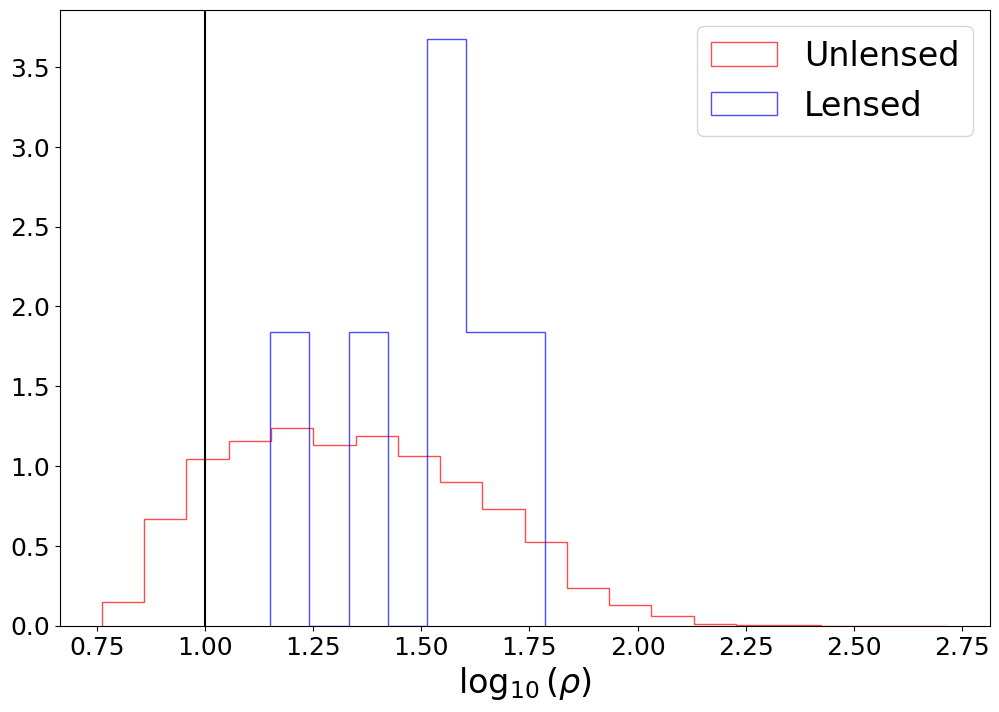

1069776
Unlensed percentage 1.0645219186072599 %
Lensed percentage 0.730816077953715 %


In [56]:
ratio_2_Nol = []
ratio_2_l =[]
for i in range(len(snr_t_Nol)):
    R = snr_t_Nol[i]/snr_rd_Nol[i]
    if R <= np.sqrt(2):
        ratio_2_Nol.append(snr_rd_Nol[i])
for i in range(len(snr_all)):
    R2 = snr_all[i]/snr_rd[i]
    if R2 <= np.sqrt(2):
        ratio_2_l.append(snr_rd[i])

plt.figure(figsize=(12, 8))
plt.hist(np.log10(ratio_2_Nol), bins = 20,density=True,histtype='step', alpha=0.7, color='red', label = "Unlensed")
plt.hist(np.log10(ratio_2_l), bins = 7,density=True,histtype='step', alpha=0.7, color='blue', label = "Lensed")
plt.axvline(1,color='black')
plt.xlabel(r'$\log_{10}(\rho)$',fontsize = 24)
#plt.title(r"Events dominated by the $SNR_{RD}$", fontsize = 24)
plt.legend(fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig("eventsdominatedbyRDSNR.jpg", dpi=300)
plt.show()
print(len(snr_t_Nol))
print("Unlensed percentage",len(ratio_2_Nol)/len(snr_t_Nol)*100,"%")
print("Lensed percentage",len(ratio_2_l)/len(snr_all)*100,"%")

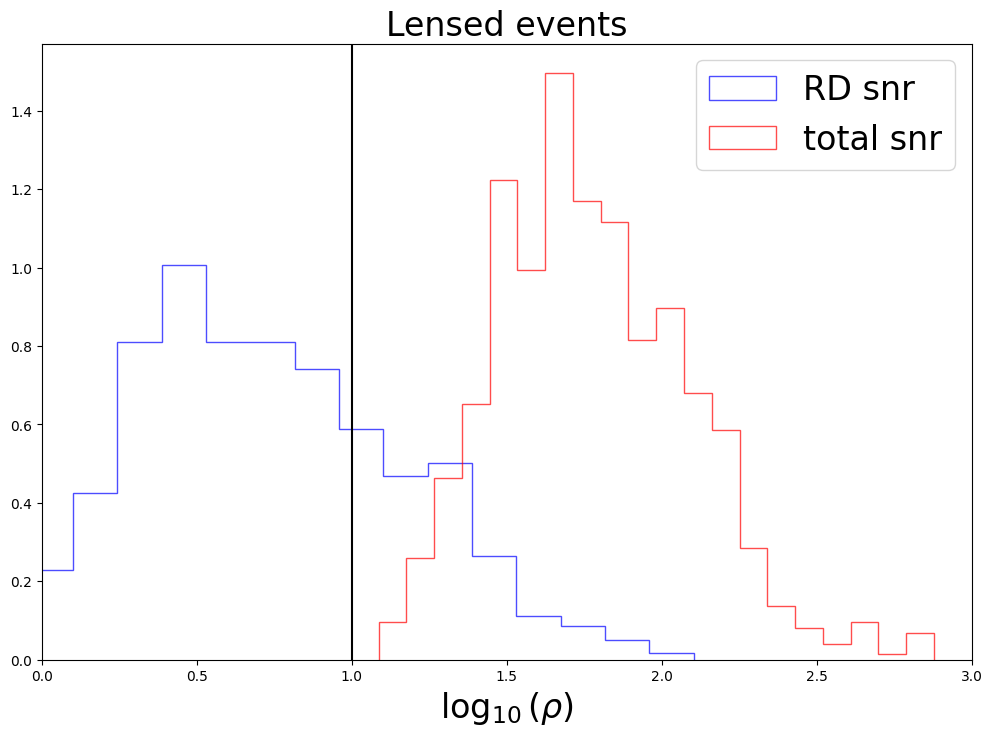

Number of total lensed evetns:  821


In [17]:
plt.figure(figsize=(12, 8))
plt.hist(np.log10(snr_rd),label = 'RD snr', bins = 20,density=True,histtype='step', alpha=0.7, color='blue')
plt.hist(np.log10(snr_all),label = 'total snr' ,bins =20,density=True,histtype='step', alpha=0.7, color='red')
plt.legend()
plt.xlim(0,3)
plt.title('Lensed events', fontsize = 24)
plt.xlabel(r'$\log_{10}(\rho)$',fontsize = 24)
plt.legend(fontsize=24)
plt.axvline(1,color='black')
plt.show()
print("Number of total lensed evetns: ", len(pop_l))

Lensed events: This plot shows a distribution of SNR (signal-to-noise ratio) in log scale for lensed events. The blue distribution shows only the SNR in the ringdown phase of a BBH while the red distribution shows the total SNR of a BBH. As observed from the plot, there is a significant amount of RD SNR events with a value lower than 10, while there is none for the total SNR. This can be explained due to the shorter and less energetic signals produced in the ringdown phase compared to the other phases of a BBH.

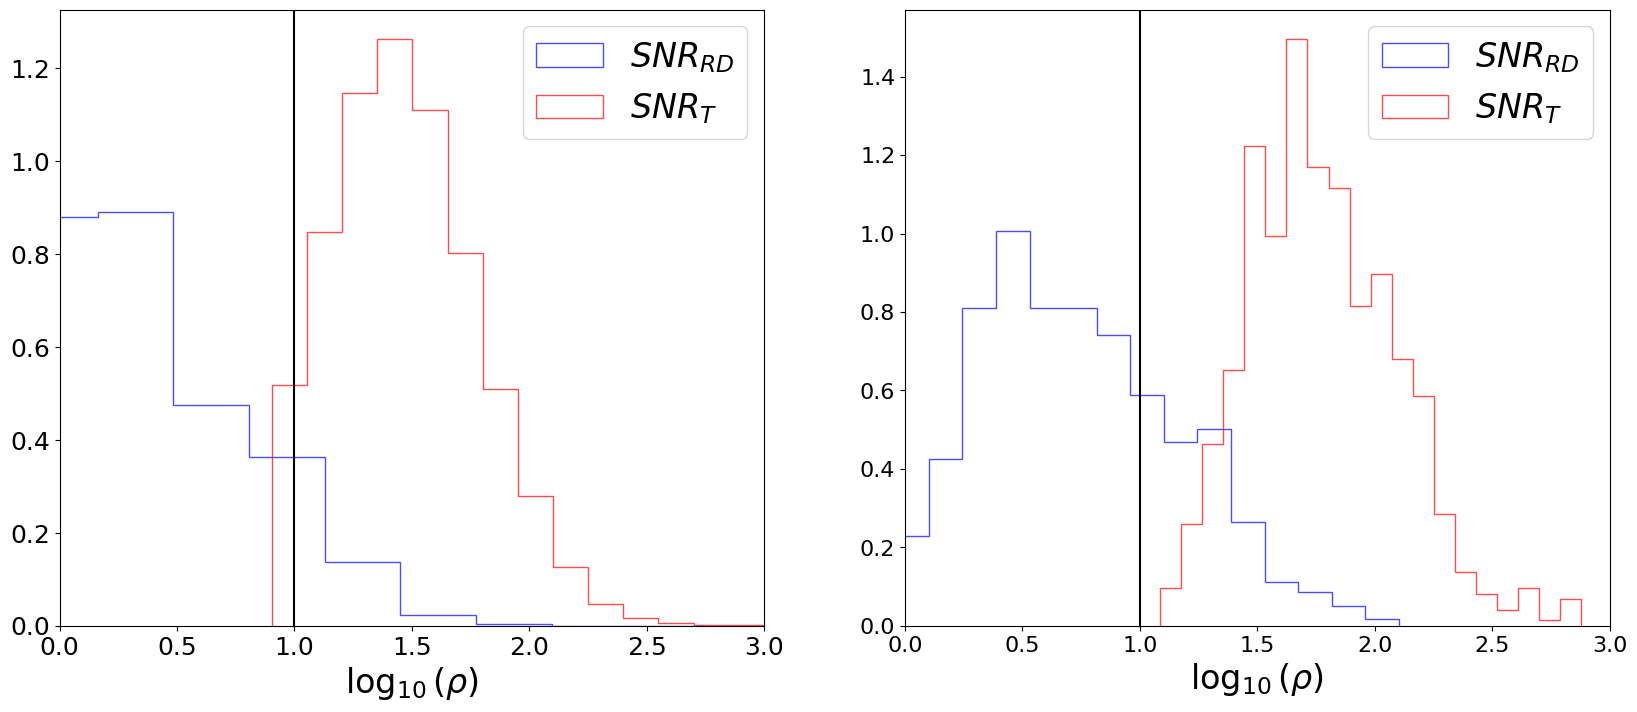

Number of total unlensed events  1069776


In [36]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
ax1, ax2 = axes
axes.flatten()
ax1.hist(np.log10(snr_rd_Nol),label = r'$SNR_{RD}$', bins = 20,density=True,histtype='step', alpha=0.7, color='blue')
ax1.hist(np.log10(snr_t_Nol),label = r'$SNR_{T}$',bins =20,density=True,histtype='step', alpha=0.7, color='red')
ax1.set_xlim(0,3)
#ax1.set_title('Unlensed events', fontsize = 24)
ax1.set_xlabel(r'$\log_{10}(\rho)$',fontsize = 24)
ax1.legend(fontsize=24)
ax1.axvline(1,color='black')
ax1.tick_params(axis='both', which='major', labelsize=18)

ax2.hist(np.log10(snr_rd),label = r'$SNR_{RD}$', bins = 20,density=True,histtype='step', alpha=0.7, color='blue')
ax2.hist(np.log10(snr_all),label = r'$SNR_{T}$' ,bins =20,density=True,histtype='step', alpha=0.7, color='red')
ax2.set_xlim(0,3)
#ax2.set_title('Lensed events', fontsize = 24)
ax2.set_xlabel(r'$\log_{10}(\rho)$',fontsize = 24)
ax2.legend(fontsize=24)
ax2.axvline(1,color='black')
ax2.tick_params(axis='both', which='major', labelsize=16)  # Set tick size

plt.savefig("SNR_comparison.jpg", dpi=300)
plt.show()
print("Number of total unlensed events ", len(pop_Nol))

Unlensed events: This plot shows a distribution of SNR (signal-to-noise ratio) in log scale for unlensed events. The blue distribution shows only the SNR in the ringdown phase of a BBH while the red distribution shows the total SNR of a BBH. As observed from the plot, there is a significant amount of RD SNR events with a value lower than 10, while there is none for the total SNR. This can be explained due to the shorter and less energetic signals produced in the ringdown phase compared to the other phases of a BBH.

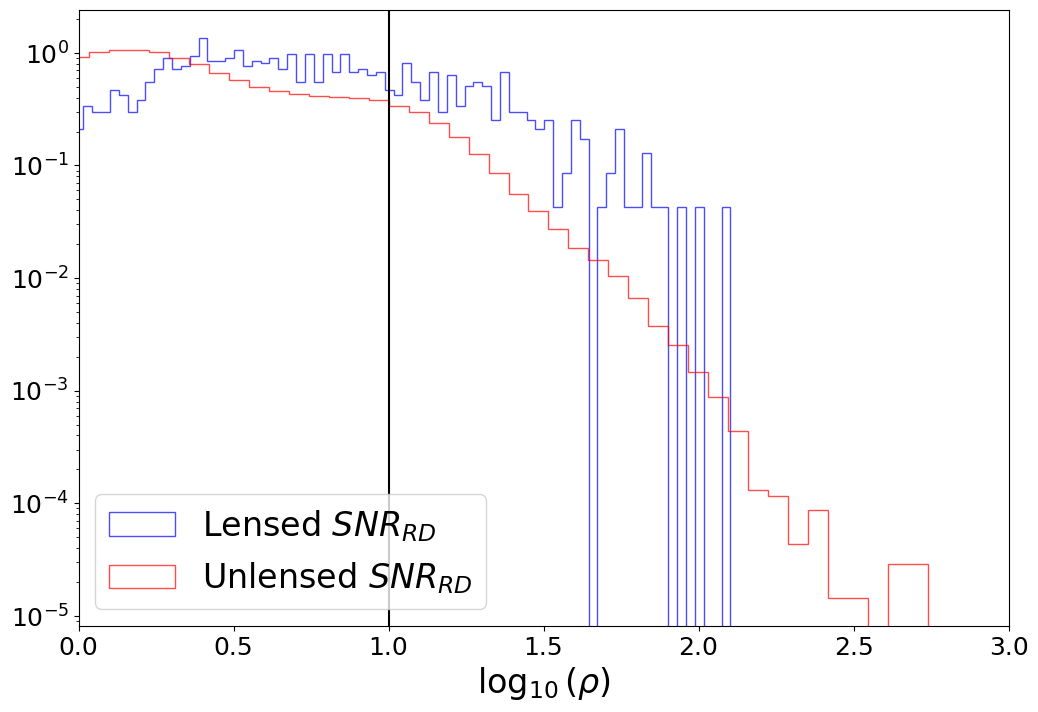

Maximum RD SNR for lensed:  126.73144517499912
Maximum RD SNR for unlensed:  550.2639749467413


In [42]:
#fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#ax1, ax2 = axes
plt.figure(figsize=(12, 8))
plt.hist(np.log10(snr_rd),label = r'Lensed $SNR_{RD}$', bins = 100,density=True,histtype='step', alpha=0.7, color='blue')
plt.hist(np.log10(snr_rd_Nol),label = r'Unlensed $SNR_{RD}$' ,bins =100,density=True,histtype='step', alpha=0.7, color='red')
plt.legend(fontsize=24)
plt.xlim(0,3)
plt.yscale("log")
#plt.title('Ringdown SNR comparison', fontsize = 24)
plt.xlabel(r'$\log_{10}(\rho)$',fontsize = 24)
plt.axvline(1,color='black')
plt.tick_params(axis='both', which='major', labelsize=18)
#ax2.hist(np.log10(snr_rd),label = 'Lensed RD snr', bins = 100,histtype='step', alpha=0.7, color='blue')
#ax2.hist(np.log10(snr_rd_Nol),label = 'Unlensed RD snr' ,bins =100,histtype='step', alpha=0.7, color='red')
#ax2.legend()
#ax2.set_xlim(0,3)
#ax2.set_yscale("log")
#ax2.set_title('Ringdown SNR comparison (Not normalised)', fontsize = 24)
#ax2.set_xlabel(r'$\log_{10}(\rho)$',fontsize = 24)
#ax2.axvline(1,color='black')
plt.savefig("snrRD.png", dpi=300)
plt.show()

#FIND MAXIMUM VALUE OF SNR RD
smax = np.sort(snr_rd)
snr_rd_max=smax[-1]
snmax = np.sort(snr_rd_Nol)
snr_rd_max_n = snmax[-1]
print("Maximum RD SNR for lensed: ", snr_rd_max)
print("Maximum RD SNR for unlensed: ", snr_rd_max_n)

Ringdown SNR comparison: This plot shows a distribution of SNR (signal-to-noise ratio) in log scale in the ringdown phase. The blue distribution shows the lensed events while the red distribution shows the unlensed events. Even though the maximum SNR for unlensed events is higher (550) than for lensed events (126), we observe a larger population of lensed events between 10 and 126, still with 1300 fewer total events than the unlensed population. 

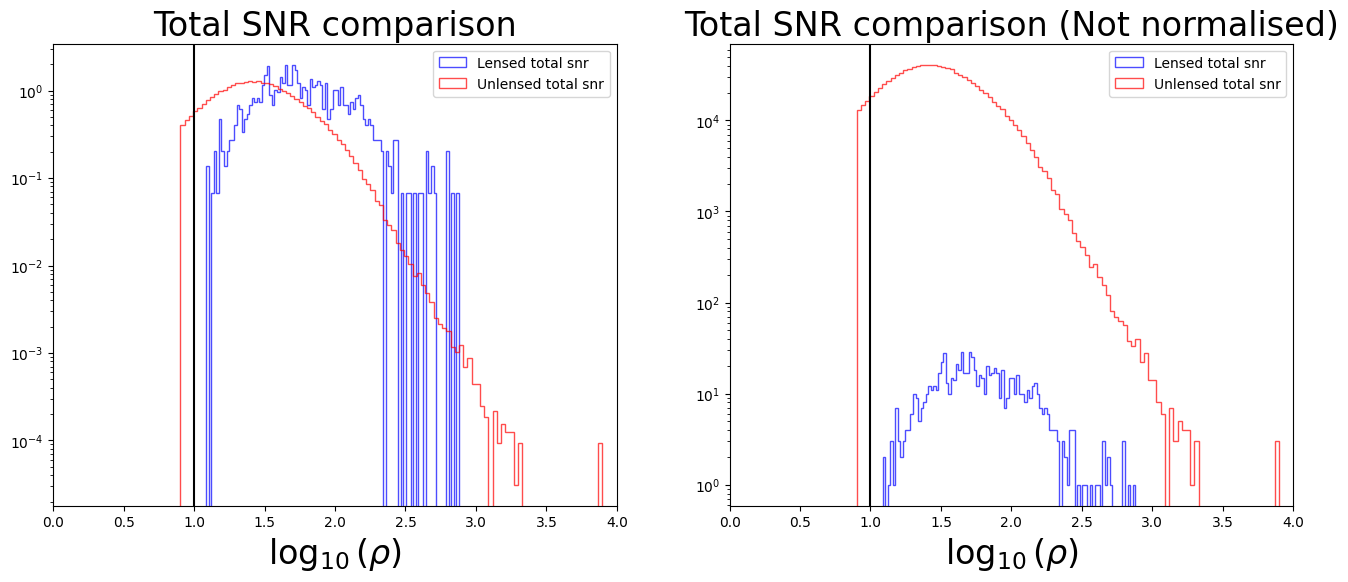

Maximum SNR for lensed:  755.0743317450786
Maximum SNR for unlensed:  7899.6012294553075


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax1, ax2 = axes
ax1.hist(np.log10(snr_all),label = 'Lensed total snr', bins = 100,density=True,histtype='step', alpha=0.7, color='blue')
ax1.hist(np.log10(snr_t_Nol),label = 'Unlensed total snr' ,bins =100,density=True,histtype='step', alpha=0.7, color='red')
ax1.legend()
ax1.set_xlim(0,4)
ax1.set_yscale("log")
ax1.set_title('Total SNR comparison', fontsize = 24)
ax1.set_xlabel(r'$\log_{10}(\rho)$',fontsize = 24)
ax1.axvline(1,color='black')
ax2.hist(np.log10(snr_all),label = 'Lensed total snr', bins = 100,histtype='step', alpha=0.7, color='blue')
ax2.hist(np.log10(snr_t_Nol),label = 'Unlensed total snr' ,bins =100,histtype='step', alpha=0.7, color='red')
ax2.legend()
ax2.set_xlim(0,4)
ax2.set_yscale("log")
ax2.set_title('Total SNR comparison (Not normalised)', fontsize = 24)
ax2.set_xlabel(r'$\log_{10}(\rho)$',fontsize = 24)
ax2.axvline(1,color='black')
plt.savefig("snrall.png", dpi=300)
plt.show()

#FIND MAXIMUM VALUE OF SNR total
stmax = np.sort(snr_all)
snr_t_max=stmax[-1]
stnmax = np.sort(snr_t_Nol)
snr_t_max_n = stnmax[-1]
print("Maximum SNR for lensed: ", snr_t_max)
print("Maximum SNR for unlensed: ", snr_t_max_n)

Total SNR comparison: Plot showing a distribution of the population of total SNR events in log scale. The blue distribution shows the lensed events while the red distribution shows the unlensed events. Again we see that the unlensed population has a higher maximum SNR, 7899 for unlensed and 755 for lensed.

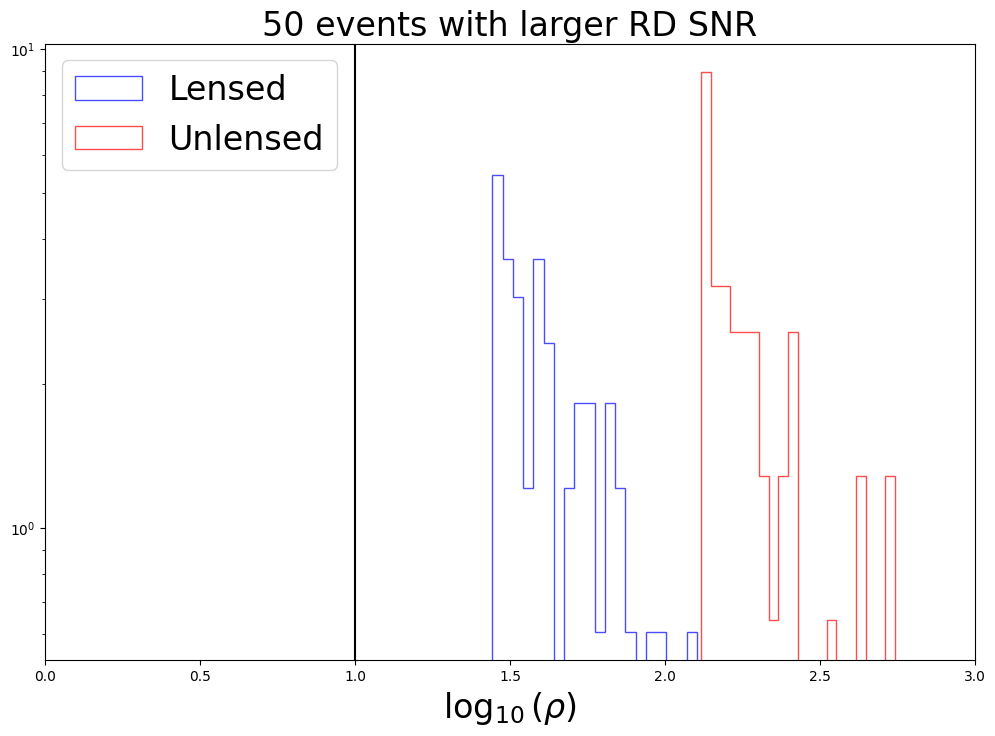

In [10]:
plt.figure(figsize=(12, 8))
plt.hist(np.log10(smax[-50:]),label = 'Lensed', bins = 20,density=True,histtype='step', alpha=0.7, color='blue')
plt.hist(np.log10(snmax[-50:]),label = 'Unlensed' ,bins =20,density=True,histtype='step', alpha=0.7, color='red')
plt.legend()
plt.xlim(0,3)
plt.title('50 events with larger RD SNR', fontsize = 24)
plt.xlabel(r'$\log_{10}(\rho)$',fontsize = 24)
plt.legend(fontsize=24)
plt.axvline(1,color='black')
plt.yscale("log")
plt.savefig("largest.png", dpi=300)

plt.show()

50 events with larger RD SNR: Plot showing 50 largest SNR events in the ringdown phase for both lensed (blue) and unlensed (red). As we can see the unlensed population has al 50 events higher than the lensed population, which matches the previous distribution plot.

In [11]:
#FRACTION OF EVENTS WITH SNR HIGHER THAN x
fraction_rd = len([snr for snr in snr_rd if snr > min_snr])/len(snr_rd)  #RD lensed events
fraction_all = len([snr for snr in snr_all if snr > min_snr])/len(snr_all)  #Total lensed events
print(" Number of events with RD SNR higher than", min_snr, ":", fraction_rd*len(pop_l), "\n", "Percentage of events with RD SNR higher than", min_snr, ":", fraction_rd*100)

 Number of events with RD SNR higher than 10 : 225.0 
 Percentage of events with RD SNR higher than 10 : 27.40560292326431


In [12]:
fraction_rdn = len([snr for snr in snr_rd_Nol if snr > 10])/len(snr_rd_Nol)  #RD unlensed events
fraction_alln = len([snr for snr in snr_t_Nol if snr > 10])/len(snr_t_Nol)  #Total unlensed events
print(" Number of events with RD SNR higher than 10:", fraction_rdn*len(pop_Nol), "\n", "Percentage of events with RD SNR higher than 10:", fraction_rdn*100)

 Number of events with RD SNR higher than 10: 99407.00000000001 
 Percentage of events with RD SNR higher than 10: 9.292319139707752


In [13]:
fraction_n_max = len([snr for snr in snr_rd_Nol if snr > snr_rd_max])/len(snr_rd_Nol) 
print("Number of non lensed events with higher snr rd than the maximum snr of lensed events: ", fraction_n_max*len(snr_rd_Nol))
print("Percentage: ", fraction_n_max*100)

Number of non lensed events with higher snr rd than the maximum snr of lensed events:  58.0
Percentage:  0.005421695756868728


In [14]:
#NUMBER OF LENSED EVENTS THAT HAVE x0, x1, x2, x3
images=[]
for year_1 in pop_l[0:]: #pop_l_fl for no _rd
    x = {}
    x['image_type'] = year_1[ 'image_type']
    images.append(x)
numerical_values=[]
for i in range(len(images)):
  first_dict = images[i]
  numerical_values = first_dict['image_type']
  zero_0 = sum(1 for image in images if image['image_type'][0] == 0.0)
  zero_1 = sum(1 for image in images if image['image_type'][1] == 0.0)
  zero_2 = sum(1 for image in images if image['image_type'][2] == 0.0)
  zero_3 = sum(1 for image in images if image['image_type'][3] == 0.0)

print(" Number of lenses with one image:",(len(images)-zero_0),"\n", "Number of lenses with two images:",
      (len(images)-zero_1), "\n",
      "Number of lenses with three images:", (len(images)-zero_2), "\n", "Number of lenses with four images:", (len(images)-zero_3))


 Number of lenses with one image: 821 
 Number of lenses with two images: 821 
 Number of lenses with three images: 149 
 Number of lenses with four images: 126


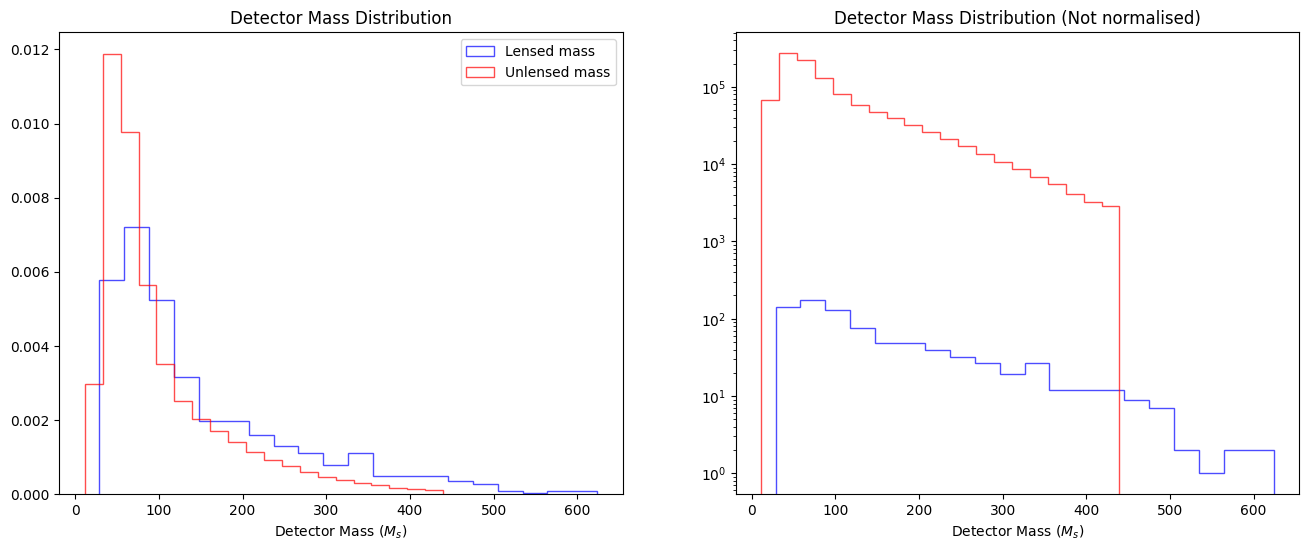

In [15]:
#MASS DISTRIBUTION AND MASS RATIO PLOTS (LENSED AND NONLENSED)
mass1=[]
mass2=[]
total_mass=[]
mass_ratio=[]
total_mass_n=[]
mass_ratio_n=[]
#lensed
for year_1 in pop_l[0:]:
    m1 = {}
    m2={}
    m1 = year_1[ 'mass1']
    m2 = year_1[ 'mass2']
    total_mass.append(m1+m1)
    mass_ratio.append(m1/m2)

#unlensed
for year_1 in pop_Nol[0:]:
    m1_n = {}
    m2_n={}
    m1_n = year_1[ 'mass_1']
    m2_n = year_1[ 'mass_2']
    total_mass_n.append(m1_n+m2_n)
    mass_ratio_n.append(m1_n/m2_n)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax1, ax2 = axes
ax1.hist(total_mass,bins = 20,label="Lensed mass",density=True,histtype='step', alpha=0.7, color='blue')
ax1.hist(total_mass_n,bins = 20,label="Unlensed mass",density=True,histtype='step', alpha=0.7, color='red')
ax1.set_title('Detector Mass Distribution')
ax1.set_xlabel(r'Detector Mass ($M_s$)')
ax1.legend()
ax2.hist(total_mass,bins = 20,label="Lensed mass",histtype='step', alpha=0.7, color='blue')
ax2.hist(total_mass_n,bins = 20,label="Unlensed mass",histtype='step', alpha=0.7, color='red')
ax2.set_title('Detector Mass Distribution (Not normalised)')
ax2.set_xlabel(r'Detector Mass ($M_s$)')
ax2.set_yscale("log")
plt.savefig("mass.png", dpi=300)

plt.show()

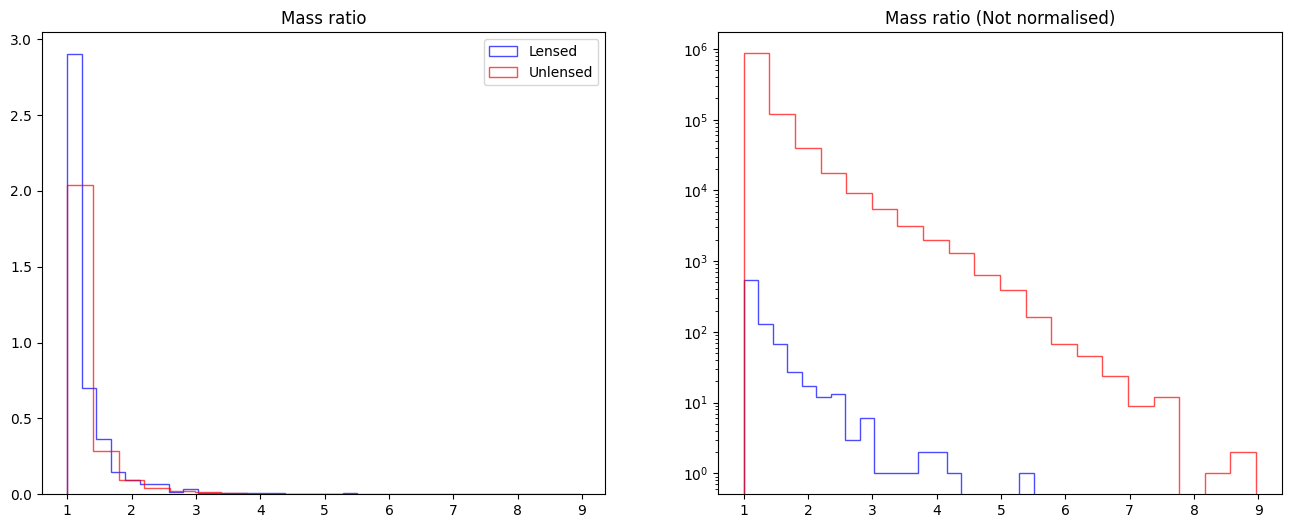

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax1, ax2 = axes
ax1.hist(mass_ratio,bins = 20,label="Lensed",density=True,histtype='step', alpha=0.7, color='blue')
ax1.hist(mass_ratio_n,bins = 20,label="Unlensed",density=True,histtype='step', alpha=0.7, color='red')
ax1.set_title('Mass ratio')
ax1.legend()
ax2.hist(mass_ratio,bins = 20,label="Lensed mass",histtype='step', alpha=0.7, color='blue')
ax2.hist(mass_ratio_n,bins = 20,label="Unlensed mass",histtype='step', alpha=0.7, color='red')
ax2.set_title('Mass ratio (Not normalised)')
ax2.set_yscale("log")

plt.show()

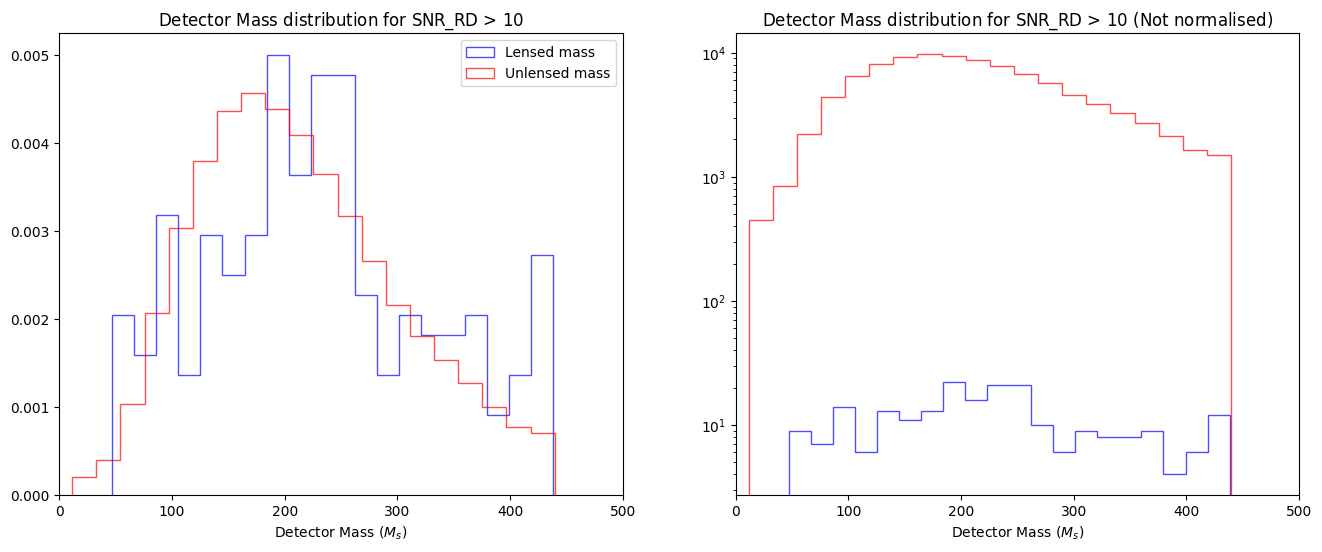

438.2576065597118
439.5396503960036


In [19]:
#MASS DISTRIBUTION FOR SNR_RD HIGHER THAN MIN_SNR
total_mass_10=[]
total_mass_n_10=[]
for i in range(len(pop_l)):
    if pop_l[i]['opt_snr_rd'] > min_snr:
        mass1 = pop_l[i]['mass1']
        mass2 = pop_l[i]['mass2']
        total_mass_10.append(mass1 + mass2)
for i in range(len(pop_Nol)):
    if pop_Nol[i]['opt_snr_net_rd'] > min_snr:
        mass1 = pop_Nol[i]['mass_1']
        mass2 = pop_Nol[i]['mass_2']
        total_mass_n_10.append(mass1 + mass2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax1, ax2 = axes
ax1.hist(total_mass_10,bins = 20,label="Lensed mass",density=True,histtype='step', alpha=0.7, color='blue')
ax1.hist(total_mass_n_10,bins = 20,label="Unlensed mass",density=True,histtype='step', alpha=0.7, color='red')
ax1.set_title(r'Detector Mass distribution for SNR_RD > ${}$'.format(min_snr))
ax1.set_xlabel(r'Detector Mass ($M_s$)')
ax1.set_xlim(0,500)
ax1.legend()
ax2.hist(total_mass_10,bins = 20,label="Lensed mass",histtype='step', alpha=0.7, color='blue')
ax2.hist(total_mass_n_10,bins = 20,label="Unlensed mass",histtype='step', alpha=0.7, color='red')
ax2.set_title(r'Detector Mass distribution for SNR_RD > ${}$ (Not normalised)'.format(min_snr))
ax2.set_xlabel(r'Detector Mass ($M_s$)')
ax2.set_yscale("log")
ax2.set_xlim(0,500)
plt.savefig("mass10.png", dpi=300)

plt.show()
sort_mass=np.sort(total_mass_10)
sort_mass_n=np.sort(total_mass_n_10)
print(sort_mass[-1])
print(sort_mass_n[-1])

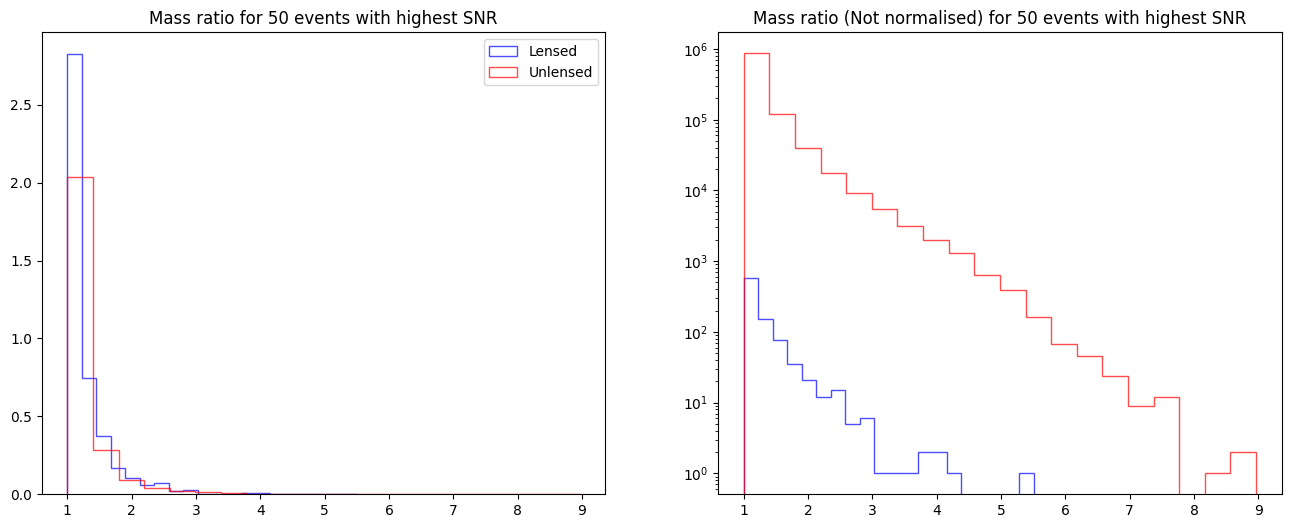

In [25]:
#MASS RATIO FOR 50 EVENTS WITH HIGHER SNR
mass_ratio_50=[]
mass_ratio_n_50=[]
min_snr_l=smax[-51]
min_snr_nol=snmax[-51]
for i in range(len(pop_l)):
    if pop_l[i]['opt_snr_rd'] > min_snr_l:
        mass1 = pop_l[i]['mass1']
        mass2 = pop_l[i]['mass2']
        mass_ratio_50.append(mass1/mass2)
for i in range(len(pop_Nol)):
    if pop_Nol[i]['opt_snr_net_rd'] > min_snr_nol:
        mass1 = pop_Nol[i]['mass_1']
        mass2 = pop_Nol[i]['mass_2']
        mass_ratio_n_50.append(mass1/mass2)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax1, ax2 = axes
ax1.hist(mass_ratio,bins = 20,label="Lensed",density=True,histtype='step', alpha=0.7, color='blue')
ax1.hist(mass_ratio_n,bins = 20,label="Unlensed",density=True,histtype='step', alpha=0.7, color='red')
ax1.set_title('Mass ratio for 50 events with highest SNR')
ax1.legend()
ax2.hist(mass_ratio,bins = 20,label="Lensed mass",histtype='step', alpha=0.7, color='blue')
ax2.hist(mass_ratio_n,bins = 20,label="Unlensed mass",histtype='step', alpha=0.7, color='red')
ax2.set_title('Mass ratio (Not normalised) for 50 events with highest SNR')
ax2.set_yscale("log")
ax1.legend()
plt.show()

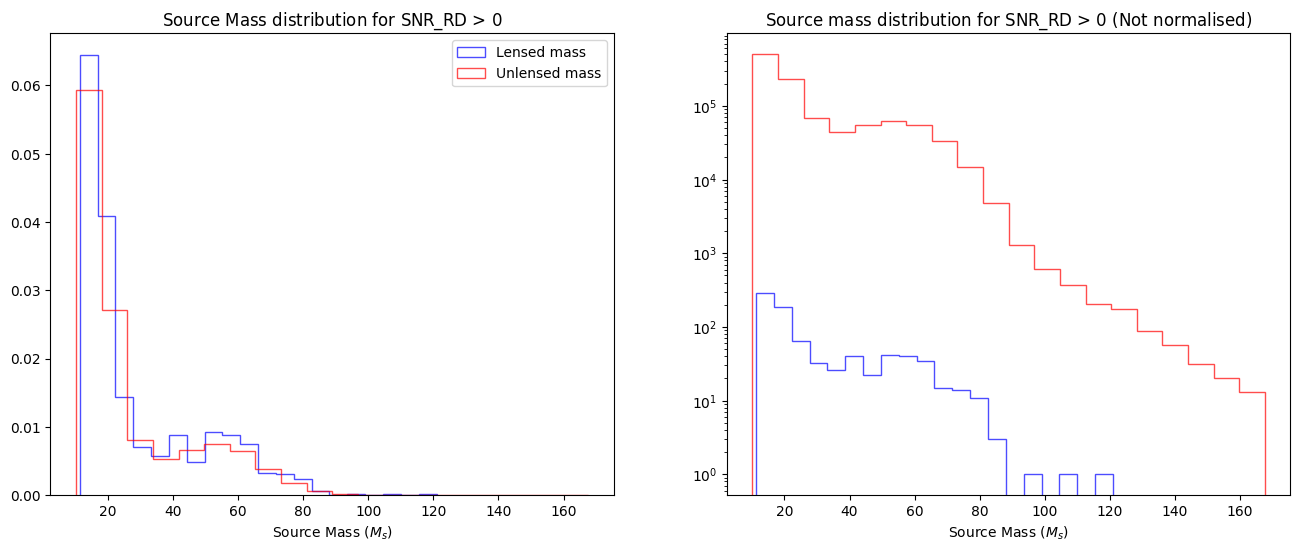

In [45]:
#SOURCE MASS DISTRIBUTION FOR SNR_RD HIGHER THAN MIN SNR
mass_source_10=[]
mass_source_n_10=[]
min_snr = 10
for i in range(len(pop_l)):
    if pop_l[i]['opt_snr_rd'] > min_snr:
        ms1 = pop_l[i]['mass_1_source']
        ms2 = pop_l[i]['mass_2_source']
        mass_source_10.append(ms1 + ms2)
for i in range(len(pop_Nol)):
    if pop_Nol[i]['opt_snr_net_rd'] > min_snr:
        ms1 = pop_Nol[i]['mass_1_source']
        ms2 = pop_Nol[i]['mass_2_source']
        mass_source_n_10.append(ms1 + ms2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax1, ax2 = axes
ax1.hist(mass_source_10,bins = 20,label="Lensed mass",density=True,histtype='step', alpha=0.7, color='blue')
ax1.hist(mass_source_n_10,bins = 20,label="Unlensed mass",density=True,histtype='step', alpha=0.7, color='red')
ax1.set_title(r'Source Mass distribution for SNR_RD > ${}$'.format(min_snr))
ax1.set_xlabel(r'Source Mass ($M_s$)')
ax1.legend()
ax2.hist(mass_source_10,bins = 20,label="Lensed mass",histtype='step', alpha=0.7, color='blue')
ax2.hist(mass_source_n_10,bins = 20,label="Unlensed mass",histtype='step', alpha=0.7, color='red')
ax2.set_title(r'Source mass distribution for SNR_RD > ${}$ (Not normalised)'.format(min_snr))
ax2.set_xlabel(r'Source Mass ($M_s$)')
ax2.set_yscale("log")
plt.show()

In [41]:
#CREATE A NEW JSON FILE WITH 821 EVENTS WITH HIGHER SNR (UNLENSED)

highest_snr_Nol = []
# Sort the pop_Nol list based on SNR in descending order
sorted_pop_Nol = sorted(pop_Nol, key=lambda x: x['opt_snr_net_rd'], reverse=True)
# Iterate through the sorted list until you have collected 821 events with highest SNR
for i in range(len(sorted_pop_Nol)):
    if len(highest_snr_Nol) == 821:
        break
    highest_snr_Nol.append(sorted_pop_Nol[i])
    
json_file_path = '/Users/arnauduranmayol/Desktop/TFM/HighestSNR_unlensed.json'
with open(json_file_path, 'w') as json_file:
    json.dump(highest_snr_Nol, json_file, indent=2)

{'mass_1': 50.18743789367172, 'mass_2': 41.071812412577344, 'mass_1_source': 37.85145238309484, 'mass_2_source': 30.97643189348987, 'zs': 0.32590520928296984, 'luminosity_distance': 1763.3931470592909, 'iota': 1.5767786189964157, 'psi': 0.8070452685738524, 'phase': 5.157065848952397, 'geocent_time': 1251373667.0, 'ra': 3.6078148377910138, 'dec': -0.92004654457846, 'a_1': 0.43208496976595423, 'a_2': 0.21916482934785564, 'tilt_1': 0.0, 'tilt_2': 0.0, 'phi_12': 0.0, 'phi_jl': 0.0, 'opt_snr_net': 519.7903603453461, 'ET': 10.853631010093864, 'CE': 519.6770318205736, 'opt_snr_net_rd': 519.7903603453462}
